#*Modelo predictivo de Churn*#

#Introducción:#
El desgaste del cliente (también conocido como abandono de clientes) es uno de los mayores gastos de cualquier organización. Si pudiéramos averiguar por qué un cliente se va y cuándo se va con una precisión razonable, ayudaría enormemente a la organización a elaborar estrategias para sus múltiples iniciativas de retención.

Nuestra investigación esta dirigida a los departamentos estratégicos de la organización encargados de la fidelización de clientes y que buscan deben investigar los motivos de deserción, segmentarlos y formular estrategias para la retención.

#Objetivo:#

El objetivo es hacer uso de un conjunto de datos de transacciones de clientes de Kaggle para comprender los pasos clave involucrados en la predicción del desgaste del cliente en Python.


#Preguntas Orientadoras#


1.  ¿Cuál es la probabilidad de que un cliente activo abandone una organización?
2.  ¿Cuáles son los indicadores clave de una rotación de clientes?
3.  ¿Qué estrategias de retención se pueden implementar en función de los resultados para disminuir la rotación de clientes potenciales? 


 

#Contexto Analitico#

Tenemos un set de datos csv con la informmación de transaccion de clientes bajado de Kaggle. En este archivo tenemos las bajas de clientes de un banco que trabaja en europa, la idea es identificar en donde se generá el churn y poder predecir cuales son los factores que determinan que el cliente va a abandonar.

#Detalle de Variables

#Importación de librerías a utilizar#

In [ ]:
#Standard libraries for data analysis:
    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Standard libraries for data visualization:
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sn.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Carga de set de datos#

El set de datos se obtiene de Kaggle. Se encuentra disponible en:

https://www.kaggle.com/datasets/halimedogan/churn-dataset?resource=download

In [ ]:
dataset = pd.read_csv("/content/churn2.csv")

#Data Wrangling

#Exploración de datos

El set de datos churn2 contiene 10.000 registros de clientes de un banco. Los siguiguientes son los campos que tiene el dataset y su descripción. 

1. **CustomerId:** Identificación de cada cliente en el dataset
2. **Surname:** Apellido del cliente.
3. **CreditScore:**  Contiene valores aleatorios 
4. **Geography:** La ubicación de un cliente 
5. **Gender:** Genero del cliente.
6. **Age:** Edad del cliente
7. **Tenure:** se refiere al número de años que el cliente ha sido cliente del banco. 
8. **Balance:** Saldo disponible de los clientes.
9. **NumOfProducts:** Refiere a la cantidad de productos que un cliente ha comprado a través del banco.
10. **HasCrCard:** Indica si un cliente tiene o no una tarjeta de crédito.
11. **IsActiveMember:** Indica si el cliente es un miembro activo del banco.
12. **EstimatedSalary:** Salario del cliente.
13. **Exited:** Indica si el cliente abandonó o no del banco.

A continuación se ilustra la parte superior del dataset.

In [ ]:
dataset.head()


Para una mayor eficiencia del análisis, verificamos que el dataset no contiene datos nulos

In [ ]:
dataset.info()

De igual manera, hacemos un mapeo de los registro duplicados, conservando el primero.

In [ ]:
dataset.duplicated(subset=None, keep='first')

Dato que los campos "CreditScore" (número aletaorio) y "RowNumber" no aportan información relevante para el analísis, eliminamos estos campos.

In [ ]:
dataset.drop(['CreditScore'],axis=1,inplace=True)
dataset.drop(['RowNumber'],axis=1,inplace=True)


Vamos a modiicar los valores de la variable Genero para dejarla con valores numericos. Reemplazando el femenino por 0 y masculino por 1.

In [ ]:
dataset['Gender'] = dataset['Gender'].map({'Female': 0, 
                                 'Male': 1, })
dataset

Un método de descripción rápida nos permite determinar que la edad media de los clientes es aproximadamente 39 años (son relativamente jovenes). En promedio, los tienen más de un producto.

In [ ]:
dataset.describe()

Dado que la variable que más importa en el modelo es el abandono, contamos las cantidades de abandono que tenemos en nuestro dataset.
El resultado indica que 7963 (79.63%) de los clientes no abandonan el banco y por lo tanto, la tasa de abandono es del 20.37%

In [ ]:
dataset['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Produndizando en el análisis, validamos la cantidad de abandono por las variables categoricas.

In [ ]:
dataset.groupby(["Geography","Age","Gender"]).Exited.sum().unstack()

Gender           0    1
Geography Age          
France    18   0.0  1.0
          19   0.0  0.0
          20   0.0  0.0
          21   0.0  1.0
          22   1.0  5.0
...            ...  ...
Spain     77   NaN  0.0
          78   0.0  0.0
          79   0.0  NaN
          80   NaN  0.0
          88   NaN  0.0

[196 rows x 2 columns]

#EDA

In [ ]:
dataset["Gender"].unique()


array(['Female', 'Male'], dtype=object)

In [ ]:
dataset["Geography"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [ ]:
dataset["NumOfProducts"].unique()

array([1, 3, 2, 4])

In [ ]:
dataset["Tenure"].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

Verificamos la distribucion del abandono (churn) en el set de datos, el conjunto de datos está desequilibrado con una alta proporción de clientes activos en comparación con sus contrapartes rotas.

In [ ]:
dataset["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Limpiamos el dataset:

In [ ]:
na_cols = dataset.isna().any()
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols["index"].tolist()
for col in dataset.columns[1:]:
     if col in na_cols:
        if dataset[col].dtype != 'object':
             dataset[col] =  dataset[col].fillna(dataset[col].mean()).round(0)

In [ ]:
dataset = dataset.sort_values(['Geography', 'Age','Tenure'])


Como los  algoritmos de ML generalmente solo pueden tener valores numéricos como sus variables independientes entendemos que la codificación de etiquetas es bastante fundamental, ya que codifican etiquetas categóricas con valores numéricos apropiados. 

Utilizamos un codigo encontrado en internet que nos permite codificar todas las variables categóricas que tienen solo dos valores únicos. Cualquier variable categórica que tenga más de dos valores únicos se trata con la codificación de etiquetas y la codificación en caliente en las secciones siguientes.

In [ ]:

from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
le_count = 0
for col in dataset.columns[1:]:
    if dataset[col].dtype == 'object':
        if len(list(dataset[col].unique())) <= 2:
            le.fit(dataset[col])
            dataset[col] = le.transform(dataset[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

0 columns were label encoded.


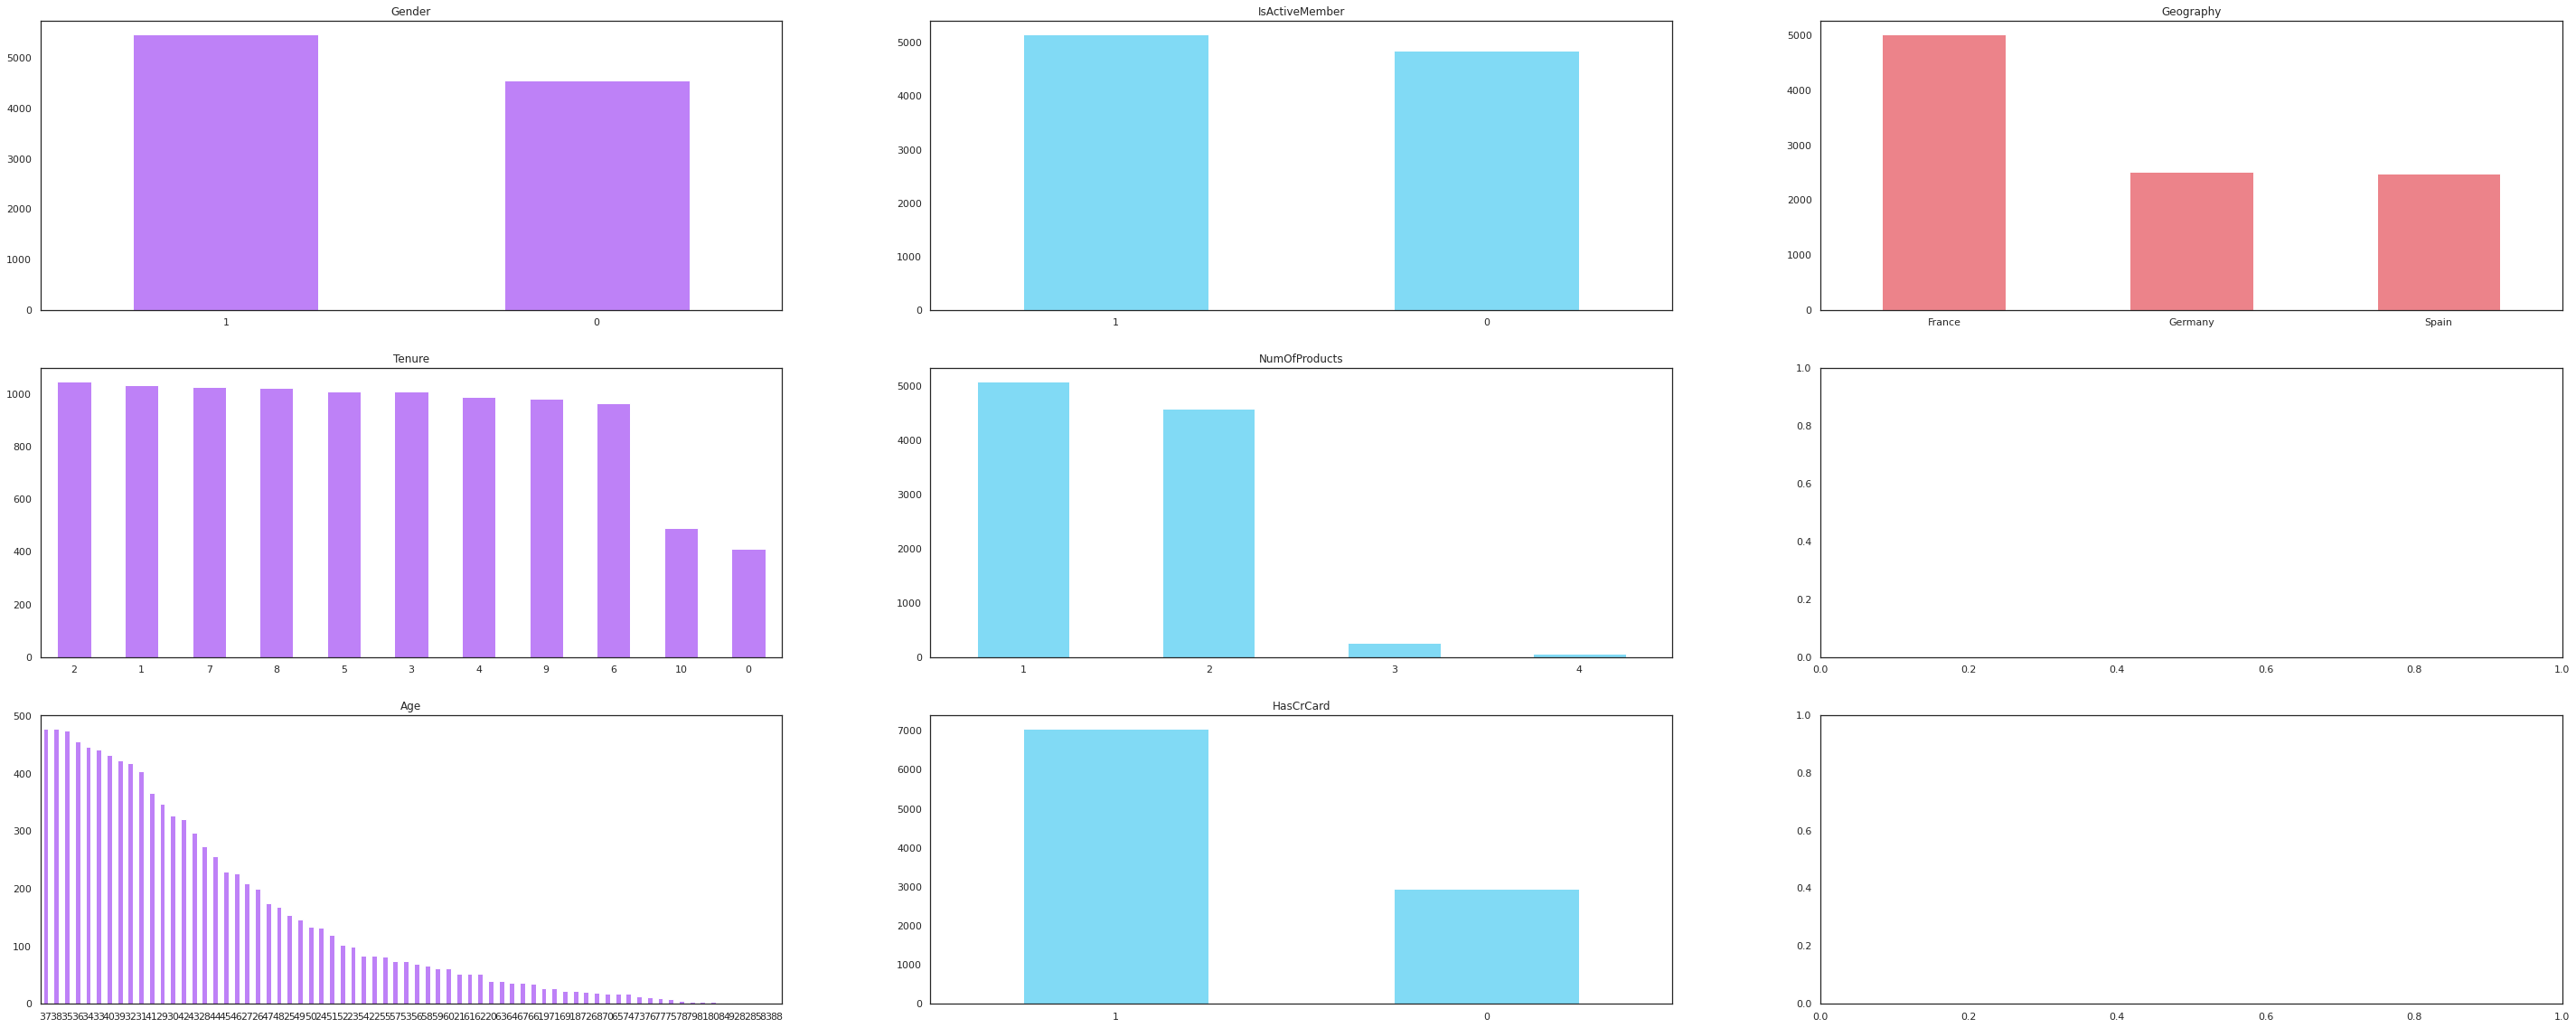

In [ ]:
Columnas = ['Gender', 'Tenure', 'Age', 'IsActiveMember','NumOfProducts','HasCrCard', 'Geography']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (50,20))
for i, item in enumerate(Columnas):
    if i < 3:
        ax = dataset[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0, color ='#BE81F7' )
        
    elif i >=3 and i < 6:
        ax = dataset[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0,color ='#81DAF5')
        
    elif i < 9:
        ax = dataset[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0,color = '#ec838a')    
    ax.set_title(item)

Estos son los comentarios que tenemos despues de haber realizado el histograma:
Se pueden hacer algunas observaciones basadas en los histogramas de las variables numéricas:

1. La distribución por género muestra que el conjunto de datos presenta una proporción relativamente igual de clientes masculinos y femeninos. Presentando más cantidad en el genero masculino.

2. La mayoría de los clientes en el conjunto de datos son personas más jóvenes.

3. La mayoría de los clientes poseen tarjeta de credito con el banco.

4. La mayoría de los clientes tienen entre 0 y 10 años de antiguedad. 

5. La mayoría de clientes tienen al menos 2 productos con el banco 

--------------------------------------------------------------------------------

En base a lo que vimos inicialmente donde teníamos un gran porcentaje de clientes que el churn figuraba activo, entedemos que este puede ser un problema de clasificación desequilibrado, por lo cual realizaremos el analisis del abandono en base a nuestras variables categoricas: **Edad** , **País**,**Cantidad de productos** y **Posee tarjeta de credito del banco**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


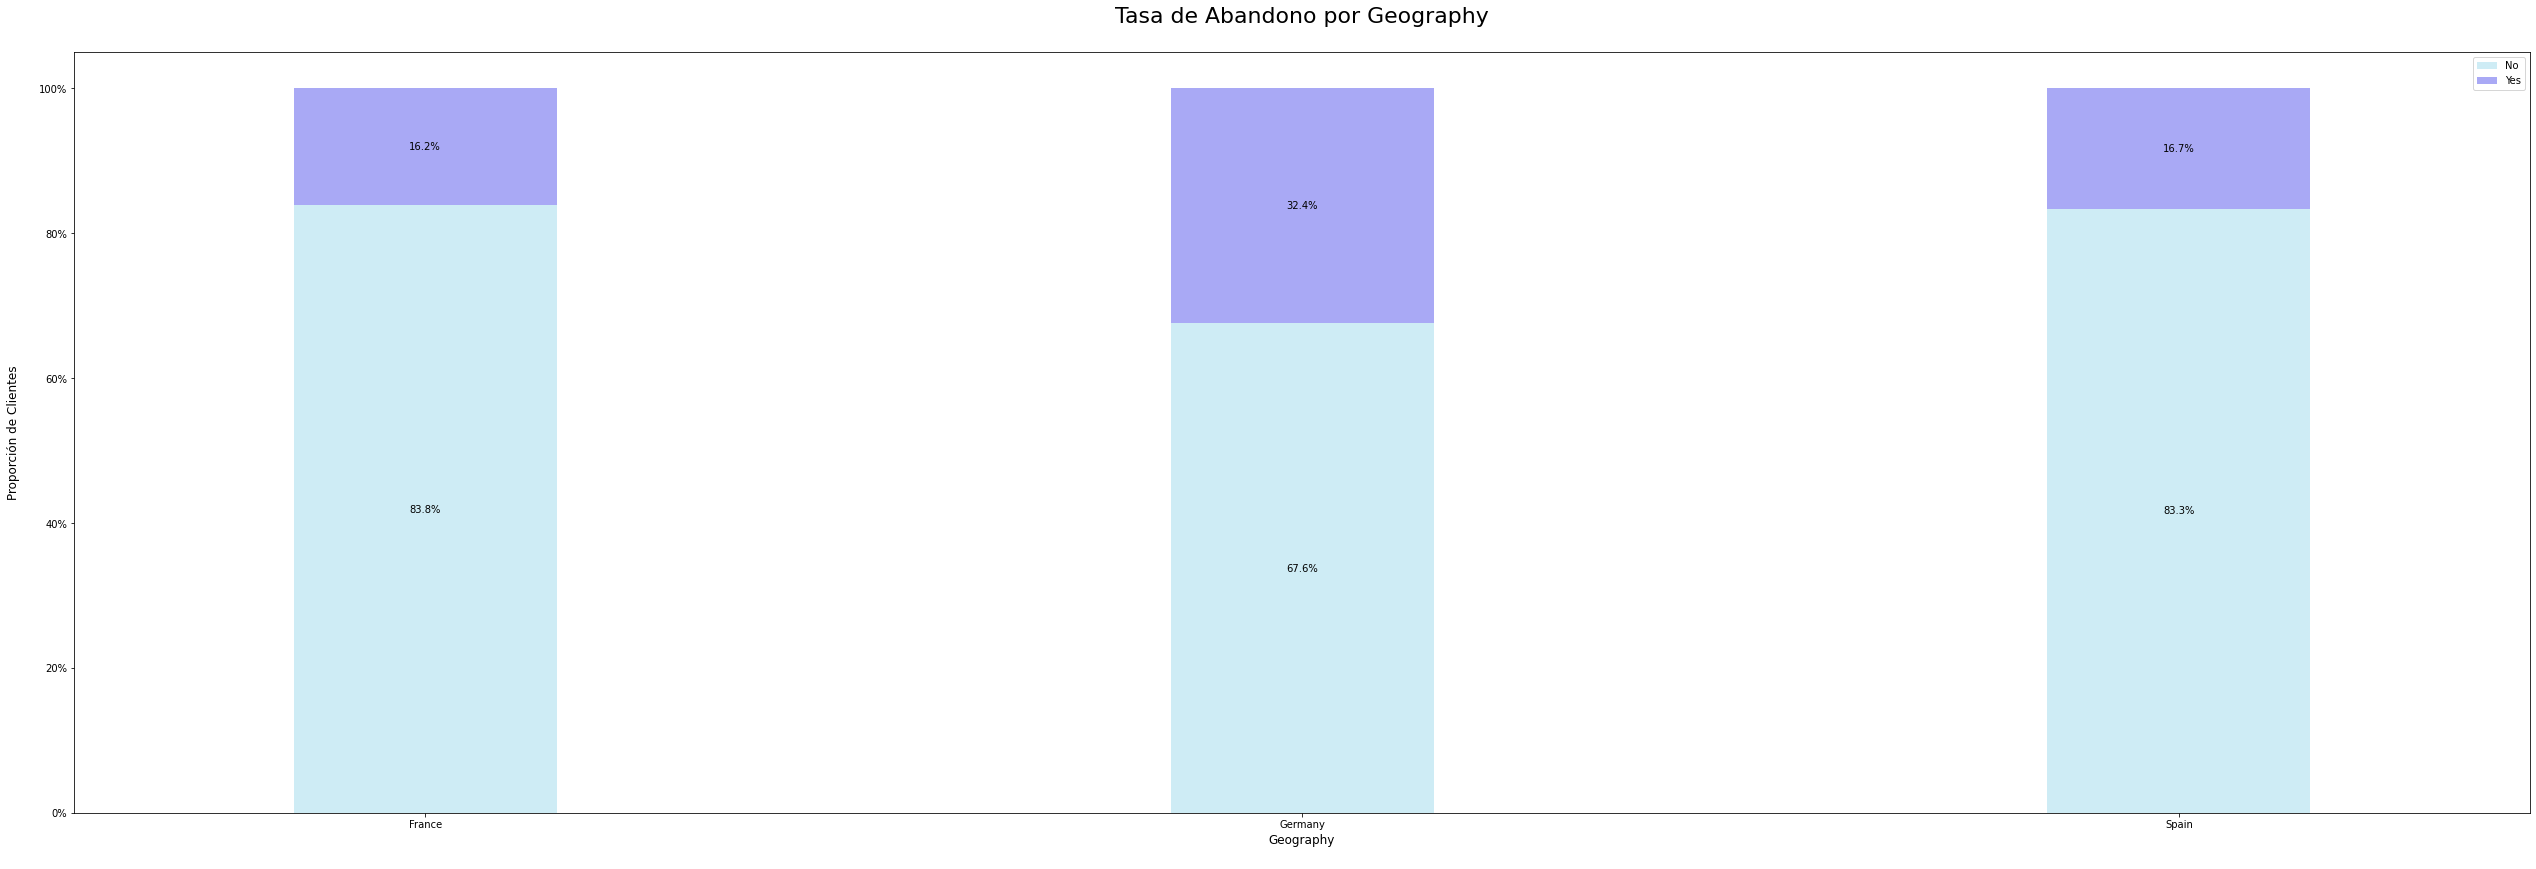

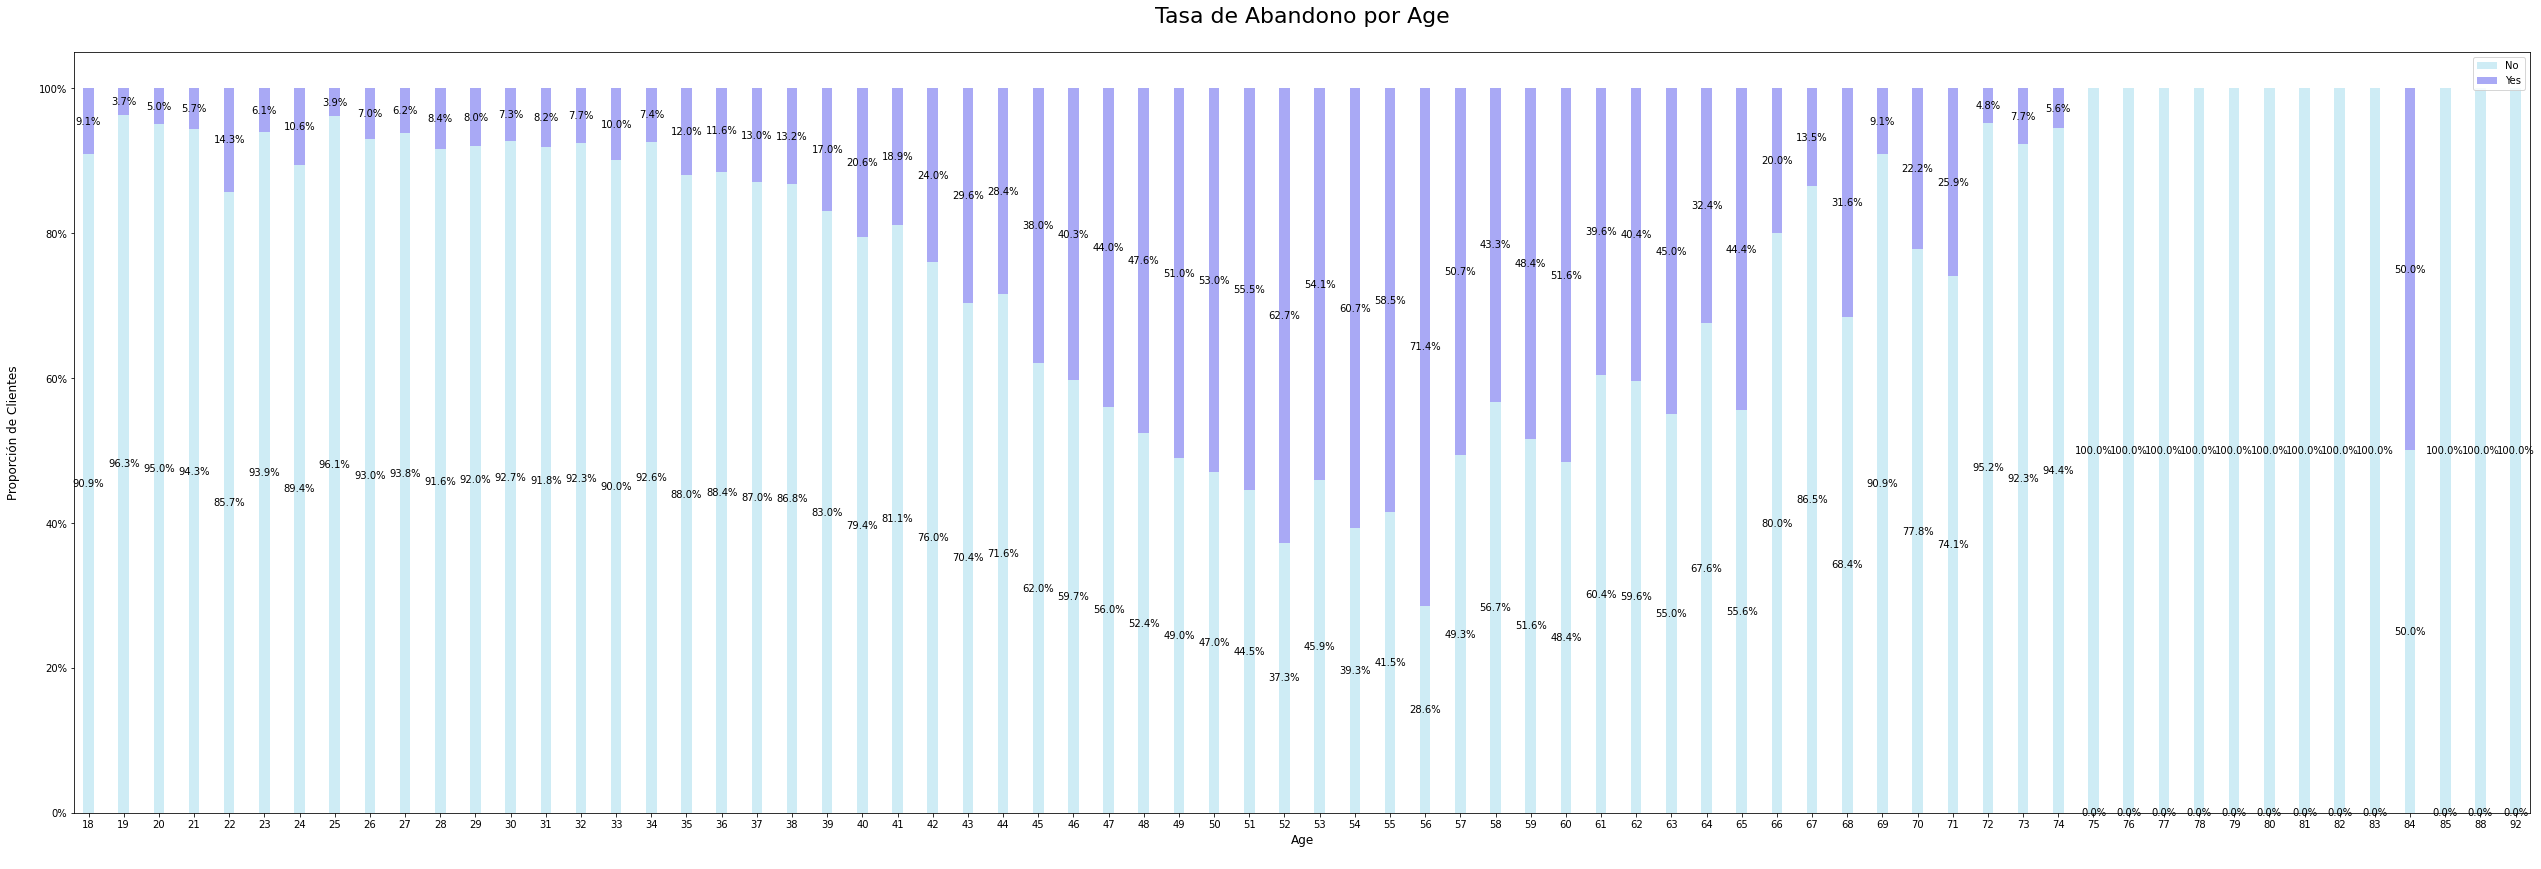

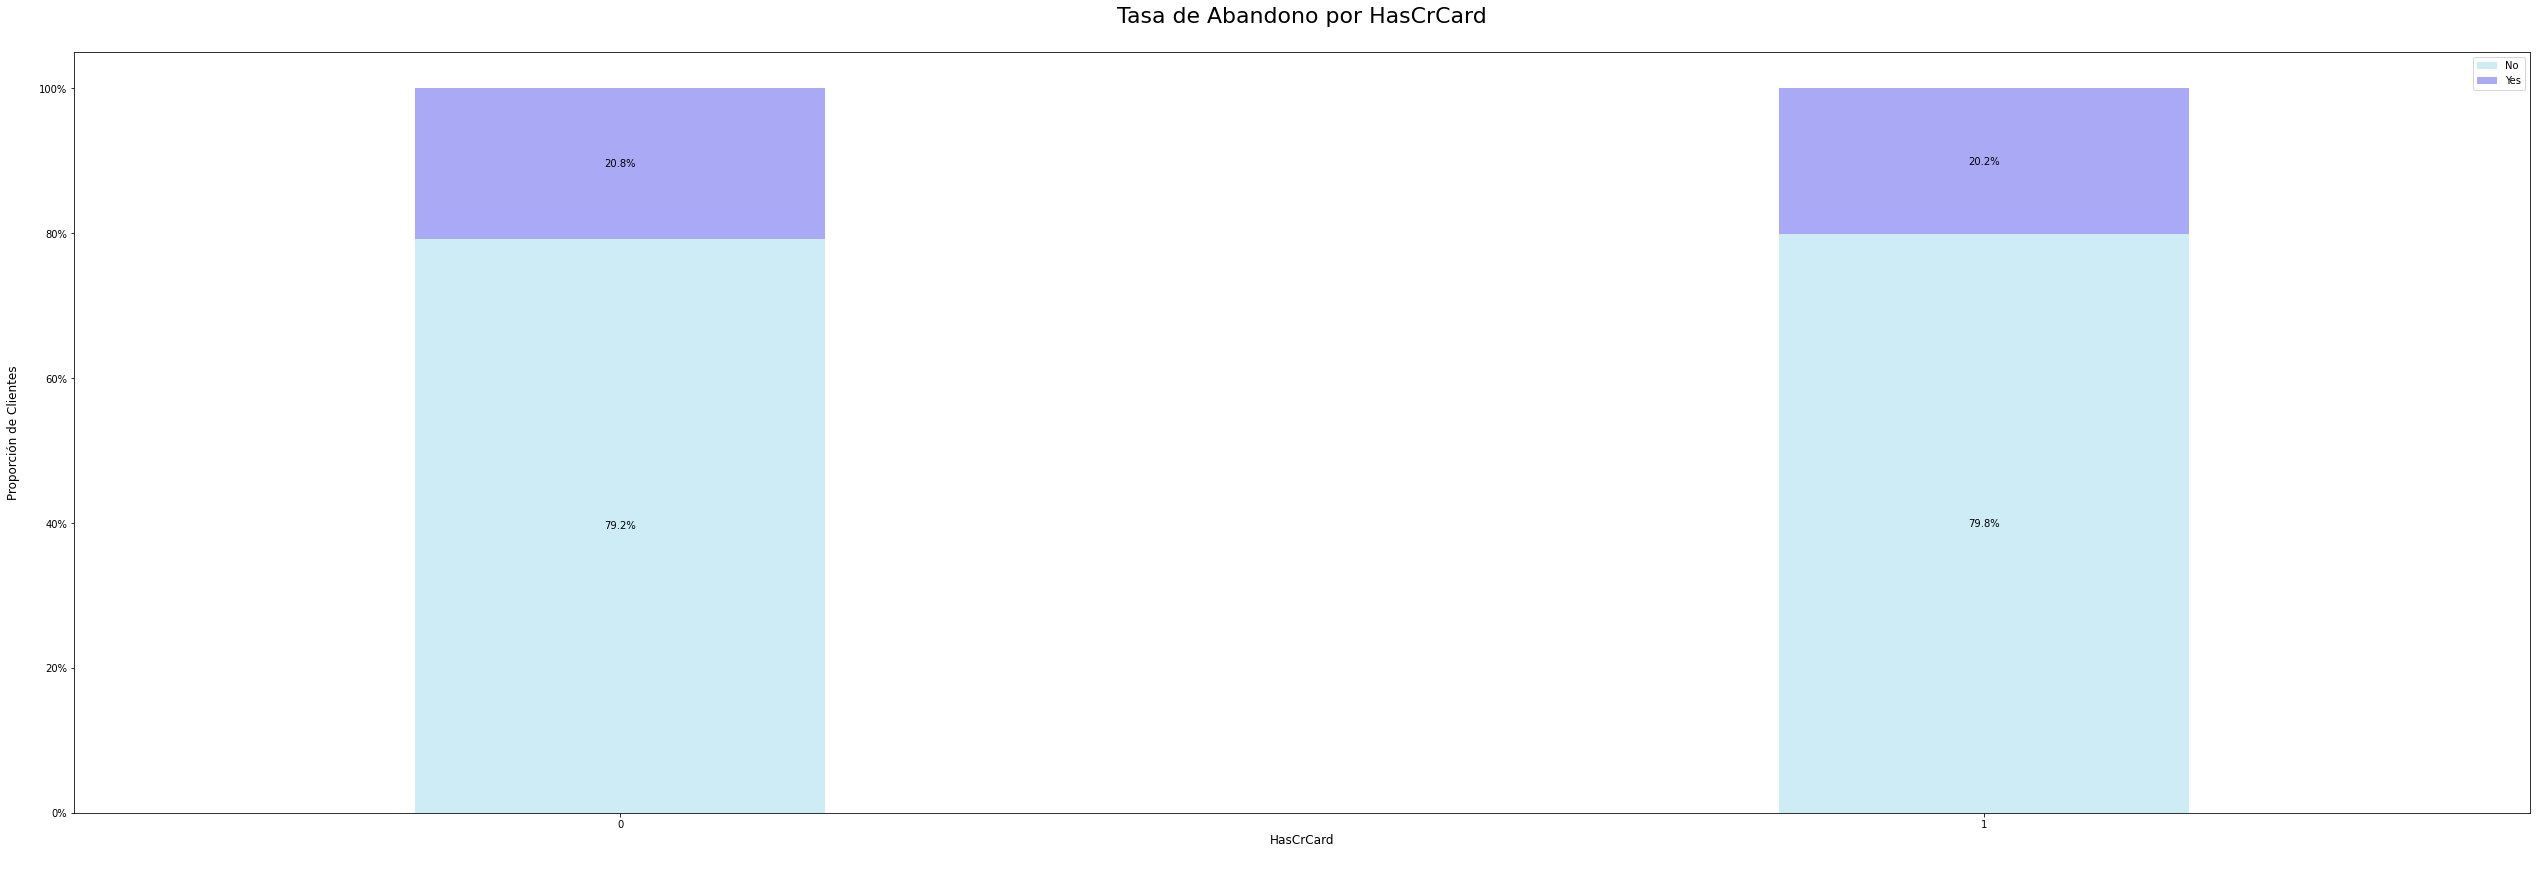

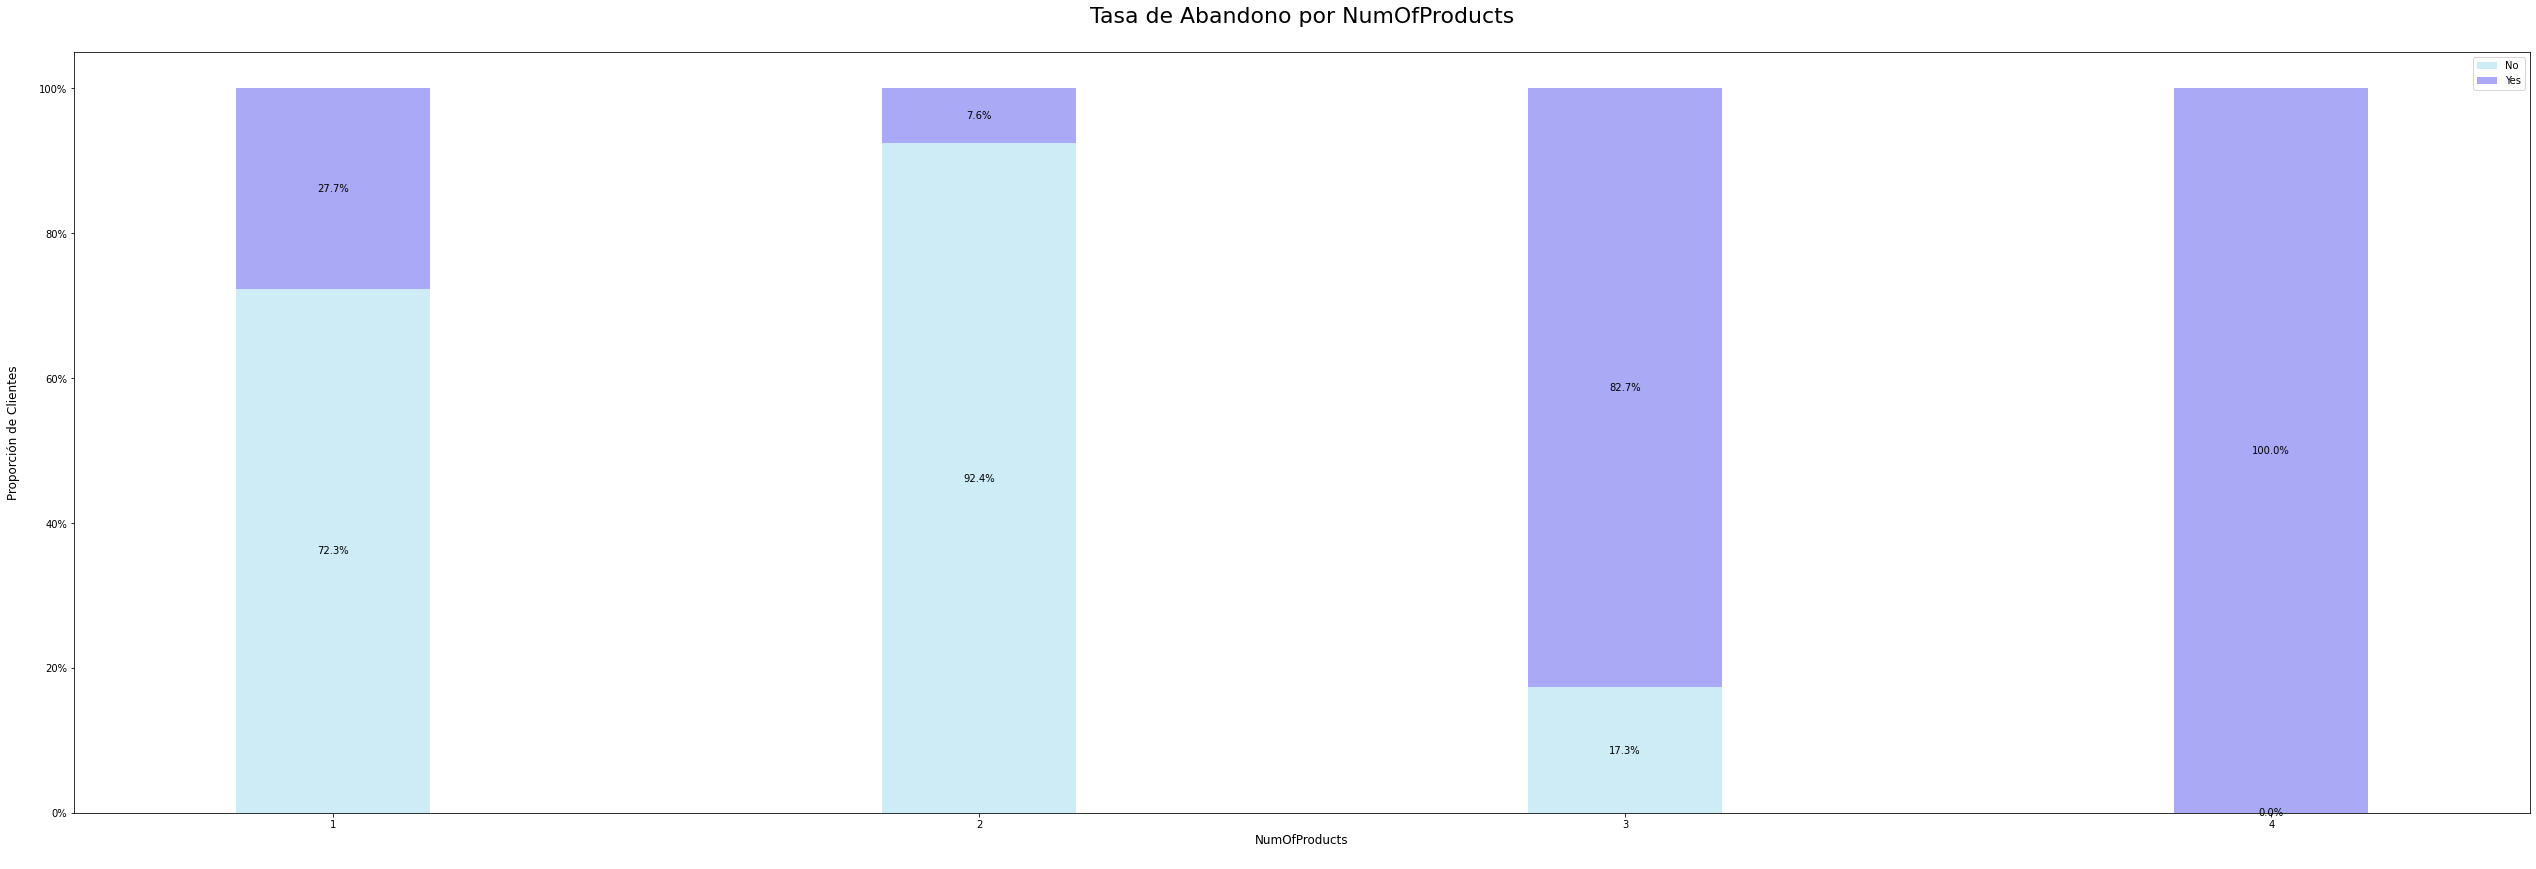

In [ ]:
columnas_categoricas = ['Geography','Age','HasCrCard','NumOfProducts']
def graficosdistribucion(col):

  import matplotlib.ticker as mtick
  contract_churn = dataset.groupby([col,'Exited']).size().unstack()
  contract_churn.rename(columns=
  {0:'No', 1:'Yes'}, inplace=True)
  colors  = ['#CEECF5','#A9A9F5', '#D0A9F5' , '#BEF781']
  ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(
  kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (44,14),
  color = colors)
  plt.ylabel('Proporción de Clientes\n',
  horizontalalignment="center",fontstyle = "normal", 
  fontsize = "large", fontfamily = "sans-serif")
  plt.xlabel(col+'\n',horizontalalignment="center",
  fontstyle = "normal", fontsize = "large", 
  fontfamily = "sans-serif")
  plt.title('Tasa de Abandono por ' +col+'\n',
  horizontalalignment="center", fontstyle = "normal", 
  fontsize = "22", fontfamily = "sans-serif")
  plt.legend(loc='top right', fontsize = "medium")
  plt.xticks(rotation=0, horizontalalignment="center")
  plt.yticks(rotation=0, horizontalalignment="right")
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())

  for p in ax.patches:
      width, height = p.get_width(), p.get_height()
      x, y = p.get_xy() 
      ax.text(x+width/2, 
              y+height/2, 
              '{:.1f}%'.format(height), 
              horizontalalignment='center', 
              verticalalignment='center')
      
  ax.autoscale(enable=False, axis='both', tight=False)


for i, item in enumerate(columnas_categoricas):
  print(8*"\n")
  graficosdistribucion(item)
  

De este grafico y basandonos en el anterior podemos ver los siguientes puntos:

1. Los clientes de los que más datos tenemos es de Francia, pero vemos que no tenemos tantos abandono de ese país. Sin embargo tenemos buena cantidad de datos en Alemania y se puede ver que es el país que más abandono tiene. 

2. Se puede ver que los clientes con edad superior a 40 y menor a 50 son los más propensos a abandonar.

3. Vemos que si bien el grafico anterior demostro que tenemos gran cantidad con clientes con Tarjeta de Credito, no suele afectar la cantidad de abandono. 

4. Se puede ver que cuando el cliente tiene 1 producto es más propenso a realizar abandono.

24/10/2022

#Trazamiento de correlaciones 


Obtenemos las variables numericas de nuestro dataset para poder realizar la correlación. Descartamos nuestra variable dependiente que es Exited (abandono)

In [ ]:
columnas_numericas = []
for col in dataset.columns: 
    if dataset[col].dtypes != 'object' and col != 'Exited':
      columnas_numericas.append(col)


Text(0.5, 1.0, 'Correlación con Abandono \n')

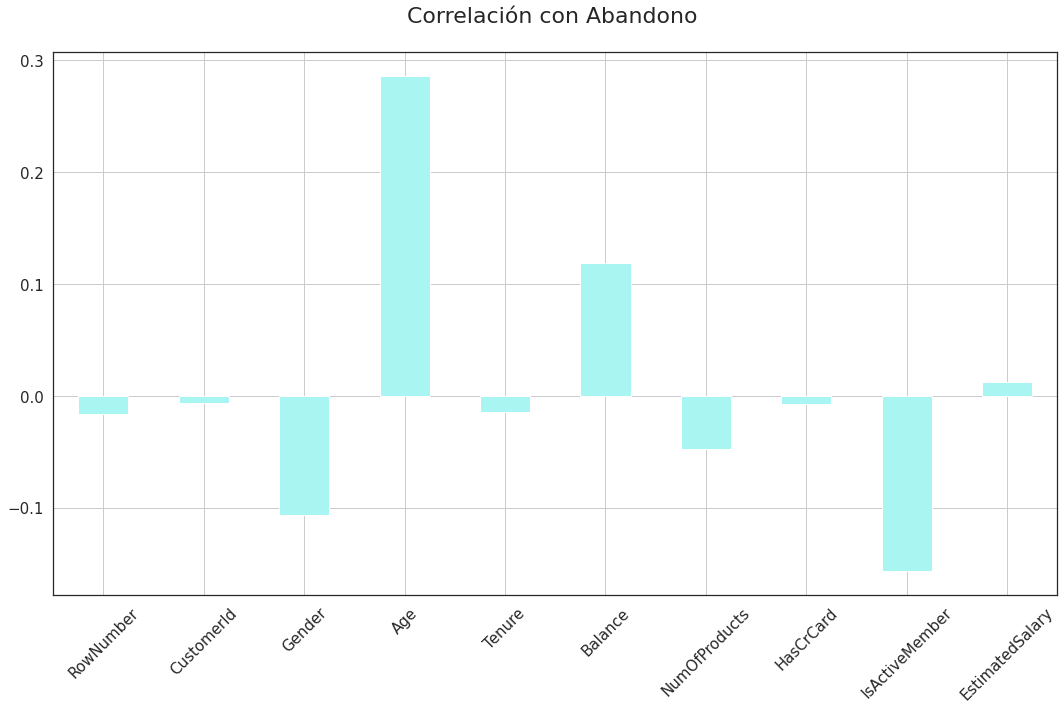

In [ ]:
dataset2 = dataset[columnas_numericas]
correlations = dataset2.corrwith(dataset.Exited)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#A9F5F2',
        rot = 45, grid = True)
plt.title('Correlación con Abandono \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

Matriz de correlacionamiento

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


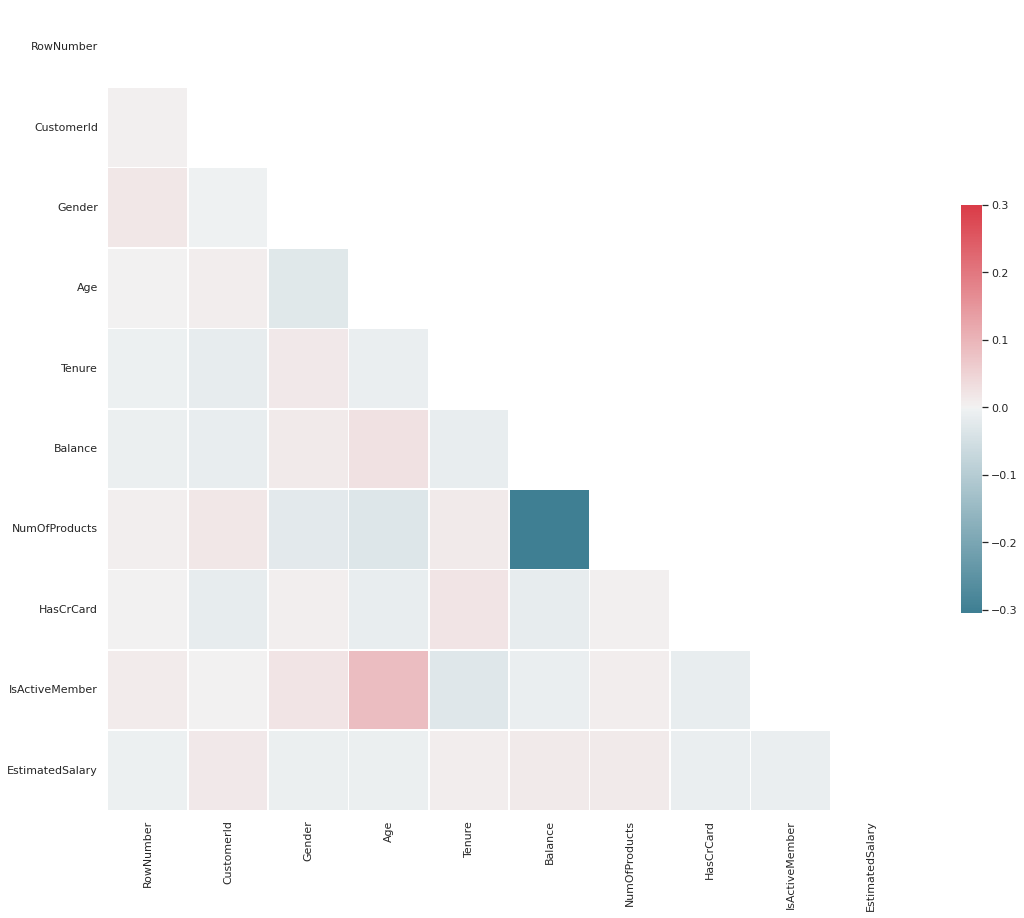

In [ ]:

sn.set(style="white")
corr = dataset2.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 15))
cmap = sn.diverging_palette(220, 10, as_cmap=True)

sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

Insights



1. El conjunto de datos no tiene valores de datos erróneos o faltantes.

2. La correlación positiva más fuerte con las características objetivo son con el balance y la edad, mientras que la correlación negativa es con el genero y si es socio activo el cliente. 

3. El conjunto de datos está desequilibrado con la mayoría de los clientes activos.

4. La mayoría de los clientes en el conjunto de datos tienen entre 30 y 50 años.

5. Hay muchos clientes antiguos en en el banco, con más de 3 años de antiguedad.

6. La mayoría de los clientes parecen tener al menos un producto contratado con el banco. 

7. Los clientes que tienen al menos un producto contratado son más propenso a abandonar el banco.